In [ ]:
!conda install selenium
!conda install -c conda-forge vadersentiment
!conda install -U spacy
!python -m spacy download en_core_web_md
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

In [1]:
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from collections import Counter
from scipy.stats import zipf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import pandas as pd
from numpy.linalg import norm
from math import log
import numpy as np
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment  import  SentimentIntensityAnalyzer
stopwords = stopwords.words('english')

In [ ]:
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

TASK-A

In [ ]:
wd = webdriver.Chrome('C:/Users/HP/Downloads/chromedriver_win32/chromedriver',options=chrome_options)
childWd = webdriver.Chrome('C:/Users/HP/Downloads/chromedriver_win32/chromedriver',options=chrome_options)
mainUrl = "https://www.beeradvocate.com/beer/{}/"

In [ ]:
def crawler(category):
    pageDf = pd.DataFrame(columns=['product_name','product_review','user_rating'])
    wd.get(mainUrl.format(category))
    tableElement = wd.find_element(by=By.XPATH,value='//*[@id="ba-content"]/table/tbody')
    rowElements = tableElement.find_elements(by=By.TAG_NAME,value='tr')
    print("Scraping comments for url {}".format(mainUrl.format(category)))
    
    #Actual table rows start from 2nd row
    for index,row in enumerate(rowElements[1:]):
        print("Scraping Table row : {}".format(index))
        link = row.find_element(by=By.TAG_NAME,value='a')
        linkUrl = link.get_attribute('href')
        childWd.get(linkUrl)
        el = childWd.find_element(by=By.XPATH,value='//*[@id="rating_fullview"]')
        comments = el.find_elements(by=By.CLASS_NAME,value='user-comment')
        for comment in comments:
            reviewContent = comment.find_element(by=By.CLASS_NAME,value='muted')
            if(reviewContent.text.startswith('Reviewed')):
                userRating = float(comment.find_element(by=By.CLASS_NAME,value='BAscore_norm').text)
                commentTags = comment.find_elements(by=By.TAG_NAME,value='div')
                userComment = commentTags[len(commentTags)-1].text
                pageDf.loc[len(pageDf.index)] = [link.text,userComment,userRating]
    return pageDf

In [ ]:
topRatedDf.head(5)

In [ ]:
topNewDf = pd.read_csv('./BeerCommentsUpdated.csv')
mergeDf = pd.concat([topRatedDf,topNewDf])
mergeDf.head(5)

In [ ]:
mergeDf.to_csv('NewAndTopRated.csv',index=False)

In [ ]:
trendingDf = crawler('trending')

In [ ]:
len(trendingDf)

In [ ]:
mergeDfTrending = pd.concat([mergeDf,trendingDf])
mergeDfTrending.drop_duplicates()

In [ ]:
topNewDf = crawler('top-new')

In [ ]:
popularDf = crawler('popular')

In [ ]:
len(popularDf)
mergeDfPopular = pd.concat([mergeDfTrending,popularDf])
mergeDfPopular.drop_duplicates()

In [ ]:
mergeFinal = pd.concat([topRatedDf,popularDf,trendingDf])
mergeFinal.drop_duplicates().to_csv('FinalData.csv',index=False)

In [ ]:
mergeFinal = mergeFinal.drop_duplicates()
mergeFinal

### TASK-B

#### Use the above attributes as examples only, for a word frequency analysis of beer reviews is a better way to find important attributes in the actual data. 
#### Assume that a customer has specified three attributes of the product as being important to him or her. 

In [267]:
# drive.mount('/content/gdrive')

beer_reviews = pd.read_csv('ScraperData.csv')

In [268]:
#Removing special character
beer_reviews['product_review'] = beer_reviews.apply(lambda x: re.sub("([!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#']+)",'',x['product_review']),axis=1)
#Removing extra lines
beer_reviews['product_review'] = beer_reviews.apply(lambda x: x['product_review'].replace('\n',' '),axis=1)
#Removing additional spaces and converting to lower case
beer_reviews['product_review'] = beer_reviews.apply(lambda x: re.sub("\\s+",' ',x['product_review'].strip().lower()),axis=1)

beer_reviews

,product_name,product_review,user_rating
0,Kentucky Brunch Brand Stout,i didnt think i was going to give it a perfect...,5.00
1,Kentucky Brunch Brand Stout,so i just read a review that called the legend...,3.79
2,Kentucky Brunch Brand Stout,2021 vintage bottle 79 holy fucking shit kbbs ...,4.64
3,Kentucky Brunch Brand Stout,celebrating my buddy rug with his 1000th beer ...,4.27
4,Kentucky Brunch Brand Stout,thick and syrupy pour mocha head aroma is booz...,4.79
...,...,...,...
5721,Bottle Shop Series #2: Highball Drifter,pours a clear brown with a ruby tint thin offw...,4.51
5722,Bottle Shop Series #2: Highball Drifter,a moderate pour into a pint glass yielded a fi...,4.44
5723,Bottle Shop Series #2: Highball Drifter,12 oz bottle born on 7721 poured into a founde...,4.50
5724,Bottle Shop Series #2: Highball Drifter,from the growler in a snifter via country fres...,4.21


In [270]:
#Tokenize word
beer_reviews['tokenized_words'] = beer_reviews.apply(lambda x: word_tokenize(x['product_review']),axis=1)
beer_reviews

,product_name,product_review,user_rating,tokenized_words
0,Kentucky Brunch Brand Stout,i didnt think i was going to give it a perfect...,5.00,"[i, didnt, think, i, was, going, to, give, it,..."
1,Kentucky Brunch Brand Stout,so i just read a review that called the legend...,3.79,"[so, i, just, read, a, review, that, called, t..."
2,Kentucky Brunch Brand Stout,2021 vintage bottle 79 holy fucking shit kbbs ...,4.64,"[2021, vintage, bottle, 79, holy, fucking, shi..."
3,Kentucky Brunch Brand Stout,celebrating my buddy rug with his 1000th beer ...,4.27,"[celebrating, my, buddy, rug, with, his, 1000t..."
4,Kentucky Brunch Brand Stout,thick and syrupy pour mocha head aroma is booz...,4.79,"[thick, and, syrupy, pour, mocha, head, aroma,..."
...,...,...,...,...
5721,Bottle Shop Series #2: Highball Drifter,pours a clear brown with a ruby tint thin offw...,4.51,"[pours, a, clear, brown, with, a, ruby, tint, ..."
5722,Bottle Shop Series #2: Highball Drifter,a moderate pour into a pint glass yielded a fi...,4.44,"[a, moderate, pour, into, a, pint, glass, yiel..."
5723,Bottle Shop Series #2: Highball Drifter,12 oz bottle born on 7721 poured into a founde...,4.50,"[12, oz, bottle, born, on, 7721, poured, into,..."
5724,Bottle Shop Series #2: Highball Drifter,from the growler in a snifter via country fres...,4.21,"[from, the, growler, in, a, snifter, via, coun..."


In [272]:
#removing stopwords
beer_reviews['tokenized_words'] = beer_reviews['tokenized_words'].apply(lambda x: [item for item in x if item not in stopwords])
lemmatizer = WordNetLemmatizer()
#Get root form of the word
beer_reviews['tokenized_words'] = beer_reviews['tokenized_words'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
beer_reviews

,product_name,product_review,user_rating,tokenized_words
0,Kentucky Brunch Brand Stout,i didnt think i was going to give it a perfect...,5.00,"[didnt, think, going, give, perfect, score, lo..."
1,Kentucky Brunch Brand Stout,so i just read a review that called the legend...,3.79,"[read, review, called, legendary, kbbs, “, typ..."
2,Kentucky Brunch Brand Stout,2021 vintage bottle 79 holy fucking shit kbbs ...,4.64,"[2021, vintage, bottle, 79, holy, fucking, shi..."
3,Kentucky Brunch Brand Stout,celebrating my buddy rug with his 1000th beer ...,4.27,"[celebrating, buddy, rug, 1000th, beer, review..."
4,Kentucky Brunch Brand Stout,thick and syrupy pour mocha head aroma is booz...,4.79,"[thick, syrupy, pour, mocha, head, aroma, booz..."
...,...,...,...,...
5721,Bottle Shop Series #2: Highball Drifter,pours a clear brown with a ruby tint thin offw...,4.51,"[pours, clear, brown, ruby, tint, thin, offwhi..."
5722,Bottle Shop Series #2: Highball Drifter,a moderate pour into a pint glass yielded a fi...,4.44,"[moderate, pour, pint, glass, yielded, fine, o..."
5723,Bottle Shop Series #2: Highball Drifter,12 oz bottle born on 7721 poured into a founde...,4.50,"[12, oz, bottle, born, 7721, poured, founder, ..."
5724,Bottle Shop Series #2: Highball Drifter,from the growler in a snifter via country fres...,4.21,"[growler, snifter, via, country, fresh, market..."


In [273]:
all_words = beer_reviews['tokenized_words'].sum()
words_frequency= nltk.FreqDist(all_words)
words_frequency

FreqDist({'beer': 5387, 'head': 4169, 'taste': 3849, 'malt': 3286, 'hop': 2743, 'flavor': 2609, 'light': 2507, 'aroma': 2483, 'good': 2412, 'note': 2362, ...})

In [274]:
words_frequency_df = pd.DataFrame(data=words_frequency.items(),columns=['Word','Frequency'])
words_frequency_df.sort_values(by='Frequency',ascending=False)

,Word,Frequency
98,beer,5387
243,head,4169
8,taste,3849
443,malt,3286
528,hop,2743
...,...,...
10085,11322,1
10087,sfloral,1
10088,tgrapefruit,1
10089,alltimer,1


In [275]:
#attributes that we selected looking at https://www.dummies.com/food-drink/drinks/beer/beer-for-dummies-cheat-sheet/
attributes = ['taste','smell','froth','fruity','hoppy','malty','robust','clarity','aggressive','flavor','sweet', \
              'note','fruit','aroma','light','malt','hop','carbonation','smooth','thick','mouthfeel','bitterness','dark']

In [276]:
#frequency distribution of these attributes in our reviews
top_10_attributes = words_frequency_df[words_frequency_df['Word'].apply(lambda x: x in attributes)].sort_values(by='Frequency',ascending=False)[:10]
top_10_attributes

,Word,Frequency
8,taste,3849
443,malt,3286
528,hop,2743
164,flavor,2609
257,light,2507
108,aroma,2483
281,note,2362
93,dark,2332
745,sweet,2194
179,carbonation,2046


Text(0.5, 1.0, 'Frequency Distribution of Beer Attributes')

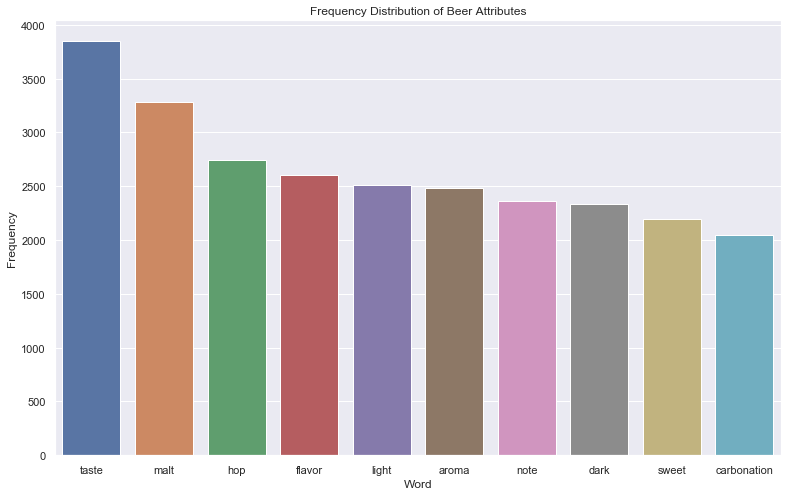

In [277]:
sns.set(font_scale=1)
plt.figure(figsize=(13,8))
sns.barplot(x='Word',y='Frequency',data=top_10_attributes)
plt.title('Frequency Distribution of Beer Attributes')

After looking at the frequency of some of the most popular attributes we conclude our **top 3 attributes as taste, malt, and hop.** We then saved it in a file for reference.

## TASK-C

#### Perform a similarity analysis using cosine similarity (without word embeddings) with the 3 attributes specified by the customer and the reviews. 

In [ ]:
#mergeFinal.to_csv('/content/gdrive/MyDrive/Unstructured Data/Assignment-2/BeerWords.csv',index=False)
#mergeFinal = pd.read_csv('/content/gdrive/MyDrive/Unstructured Data/Assignment-2/BeerWords.csv')
beer_reviews

In [278]:
user_attributes = pd.read_csv('attributes.txt').columns.values
user_attributes

array(['taste', 'malt', 'hop'], dtype=object)

In [279]:
def attributeCounter(s,i):
    wordDict = Counter(s)
    return wordDict[i]

def cosine(s1,s2):
    return (np.dot(s1,s2))/(norm(s1)*norm(s2))

In [281]:
for i in productList:
    beer_reviews[i] = beer_reviews['tokenized_words'].apply(lambda x: attributeCounter(x,i))
  
attribute_idf_vector = np.array([1,1,1])

beer_reviews['similarity_score'] = beer_reviews.iloc[:,4:].apply(lambda x: cosine(x.values,attribute_idf_vector),axis=1).sort_values(ascending=False)
#beerDf[['product_name','product_review','Similarity Score']].to_csv('/content/gdrive/MyDrive/Unstructured Data/Assignment-2/Cosine Similarity.csv',index=False)


/Users/dishagandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [282]:
beer_reviews['similarity_score'] = beer_reviews['similarity_score'].fillna(0)
beer_reviews

,product_name,product_review,user_rating,tokenized_words,taste,malt,hop,similarity_score
0,Kentucky Brunch Brand Stout,i didnt think i was going to give it a perfect...,5.00,"[didnt, think, going, give, perfect, score, lo...",2,0,0,0.57735
1,Kentucky Brunch Brand Stout,so i just read a review that called the legend...,3.79,"[read, review, called, legendary, kbbs, “, typ...",0,0,0,0.00000
2,Kentucky Brunch Brand Stout,2021 vintage bottle 79 holy fucking shit kbbs ...,4.64,"[2021, vintage, bottle, 79, holy, fucking, shi...",1,0,0,0.57735
3,Kentucky Brunch Brand Stout,celebrating my buddy rug with his 1000th beer ...,4.27,"[celebrating, buddy, rug, 1000th, beer, review...",0,0,0,0.00000
4,Kentucky Brunch Brand Stout,thick and syrupy pour mocha head aroma is booz...,4.79,"[thick, syrupy, pour, mocha, head, aroma, booz...",0,0,0,0.00000
...,...,...,...,...,...,...,...,...
5721,Bottle Shop Series #2: Highball Drifter,pours a clear brown with a ruby tint thin offw...,4.51,"[pours, clear, brown, ruby, tint, thin, offwhi...",0,0,0,0.00000
5722,Bottle Shop Series #2: Highball Drifter,a moderate pour into a pint glass yielded a fi...,4.44,"[moderate, pour, pint, glass, yielded, fine, o...",2,0,0,0.57735
5723,Bottle Shop Series #2: Highball Drifter,12 oz bottle born on 7721 poured into a founde...,4.50,"[12, oz, bottle, born, 7721, poured, founder, ...",0,0,0,0.00000
5724,Bottle Shop Series #2: Highball Drifter,from the growler in a snifter via country fres...,4.21,"[growler, snifter, via, country, fresh, market...",0,0,0,0.00000


We used a very simple approach for calculating similarity which was finding the **cosine similarity between the term frequency count for top 3 attributes with a unit array.**

## TASK-D

#### For every review, perform a sentiment analysis (using VADER).

In [284]:
def vaderScore(review):
    sdr = SentimentIntensityAnalyzer()
    sentiment_dict = sdr.polarity_scores(' '.join(review))
    if(sentiment_dict['compound']>=0.5):
        return 'Positive',sentiment_dict['compound']
    elif(sentiment_dict['compound']<=-0.05):
        return 'Negative',sentiment_dict['compound']
    else:
        return 'Neutral',sentiment_dict['compound']
    print(sentiment_dict)
    

In [285]:
beer_reviews['vader_score'] = beer_reviews['tokenized_words'].apply(lambda x: vaderScore(x))

In [286]:
beer_reviews['sentiment'],beer_reviews['compound_score'] = zip(*beer_reviews['vader_score'])

In [287]:
beer_reviews['sentiment'].value_counts()

Positive    4947
Neutral      547
Negative     232
Name: sentiment, dtype: int64

Using the VADER Sentiment Analysis we calculated Sentiment Score on all reviews. The **Compound Score** represents the Sentiment Score and VADER Score represents the total sentiment along with the score

## TASK-E

#### Create an evaluation score for each beer that uses both similarity and sentiment scores. Now recommend 3 products to the customer.

In [288]:
sentiment_avg = beer_reviews.groupby('product_name')['compound_score'].mean().reset_index()
sentiment_avg = sentiment_avg.sort_values('compound_score', ascending=False)
sentiment_avg = sentiment_avg.reset_index(drop=True)

similarity_avg = beer_reviews.groupby('product_name')['similarity_score'].mean().reset_index()
similarity_avg = similarity_avg.sort_values('similarity_score', ascending=False)
similarity_avg = similarity_avg.reset_index(drop=True)

review = similarity_avg.merge(sentiment_avg, on='product_name')
review['evaluation_score'] = review[['similarity_score','compound_score']].mean(axis=1)
recommended = review.sort_values(by='evaluation_score', ascending=False,ignore_index=True)
print(f"The Top 3 recommendations based on Bag of Words similarity scores are: \n1.{recommended.product_name[0]}\n2.{recommended.product_name[1]} \n3.{recommended.product_name[2]}")

The Top 3 recommendations based on Bag of Words similarity scores are: 
1.Export Lager
2.Prince Percy 
3.Everett


In [289]:
recommended.head(3)

,product_name,similarity_score,compound_score,evaluation_score
0,Export Lager,0.805226,0.939420,0.872323
1,Prince Percy,0.783475,0.923625,0.853550
2,Everett,0.780279,0.920964,0.850621


## TASK-F

#### How would your recommendation change if you use word vectors (e.g., the spaCy package with medium sized pretrained word vectors) instead of the plain vanilla bag-of-words cosine similarity? One way to analyze the difference would be to consider the % of reviews that mention a preferred attribute. 

In [290]:
nlp = spacy.load('en_core_web_md')
att1 = productList[0]
att2 = productList[1]
att3 = productList[2]

def calculate_similarity(review, att):
    review_word2vec = nlp(review)
    sim_score = review_word2vec.similarity(nlp(att))
    return sim_score

beer_reviews['sim_score_'+att1] = beer_reviews['product_review'].apply(lambda x: calculate_similarity(x,att1))
beer_reviews['sim_score_'+att2] = beer_reviews['product_review'].apply(lambda x: calculate_similarity(x,att2))
beer_reviews['sim_score_'+att3] = beer_reviews['product_review'].apply(lambda x: calculate_similarity(x,att3))
beer_reviews.head()

,product_name,product_review,user_rating,tokenized_words,taste,malt,hop,similarity_score,vader_score,sentiment,compound_score,sim_score_taste,sim_score_malt,sim_score_hop
0,Kentucky Brunch Brand Stout,i didnt think i was going to give it a perfect...,5.00,"[didnt, think, going, give, perfect, score, lo...",2,0,0,0.57735,"(Positive, 0.9612)",Positive,0.9612,0.405821,0.102065,0.483786
1,Kentucky Brunch Brand Stout,so i just read a review that called the legend...,3.79,"[read, review, called, legendary, kbbs, “, typ...",0,0,0,0.00000,"(Positive, 0.9968)",Positive,0.9968,0.378481,0.133472,0.453290
2,Kentucky Brunch Brand Stout,2021 vintage bottle 79 holy fucking shit kbbs ...,4.64,"[2021, vintage, bottle, 79, holy, fucking, shi...",1,0,0,0.57735,"(Positive, 0.9846)",Positive,0.9846,0.454938,0.187034,0.480563
3,Kentucky Brunch Brand Stout,celebrating my buddy rug with his 1000th beer ...,4.27,"[celebrating, buddy, rug, 1000th, beer, review...",0,0,0,0.00000,"(Positive, 0.9679)",Positive,0.9679,0.466890,0.190951,0.436962
4,Kentucky Brunch Brand Stout,thick and syrupy pour mocha head aroma is booz...,4.79,"[thick, syrupy, pour, mocha, head, aroma, booz...",0,0,0,0.00000,"(Positive, 0.8225)",Positive,0.8225,0.466242,0.234681,0.390799


In [291]:
reviews_spacy = beer_reviews.groupby('product_name')['sim_score_'+att1,'sim_score_'+att2,'sim_score_'+att3].mean().reset_index()
reviews_spacy['spacy_similarity_score'] = (reviews_spacy['sim_score_'+att1] + reviews_spacy['sim_score_'+att2] + reviews_spacy['sim_score_'+att3])/3  
reviews_spacy = reviews_spacy.sort_values(by = 'spacy_similarity_score', ascending=False, ignore_index=True)

reviews_spacy.head(3)

/Users/dishagandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,product_name,sim_score_taste,sim_score_malt,sim_score_hop,spacy_similarity_score
0,Lou Pepe - Kriek,0.548038,0.246700,0.393944,0.396227
1,All That Is And All That Ever Will Be,0.537319,0.270865,0.380015,0.396066
2,Pressed - Stroopwafel,0.517977,0.262370,0.399232,0.393193


In [292]:
print(f"The top 3 recommendations based on Word Vectors similarity scores are: \n1.{reviews_spacy.product_name[0]}\n2.{reviews_spacy.product_name[1]} \n3.{reviews_spacy.product_name[2]}")

The top 3 recommendations based on Word Vectors similarity scores are: 
1.Lou Pepe - Kriek
2.All That Is And All That Ever Will Be 
3.Pressed - Stroopwafel


In [293]:
recommended_spacy = reviews_spacy.merge(sentiment_avg, on='product_name')
recommended_spacy['spacy evaluation score'] = (recommended_spacy['spacy_similarity_score']+recommended_spacy['compound_score'])
recommended_spacy = recommended_spacy.sort_values('spacy evaluation score', ascending=False, ignore_index=True)
recommended_spacy.head(3)

,product_name,sim_score_taste,sim_score_malt,sim_score_hop,spacy_similarity_score,compound_score,spacy evaluation score
0,Double Shot,0.482421,0.225609,0.405515,0.371182,0.963333,1.334515
1,Aurelian Lure,0.470207,0.215274,0.419829,0.368437,0.961700,1.330137
2,Red Eye November,0.473736,0.235932,0.384817,0.364828,0.960250,1.325078


In [294]:
print(f"The top 3 recommendations based on Word Vectors similarity combined with sentiment scores are:\n1. {recommended_spacy.product_name[0]} \n2. {recommended_spacy.product_name[1]} \n3. {recommended_spacy.product_name[2]}")

The top 3 recommendations based on Word Vectors similarity combined with sentiment scores are:
1. Double Shot 
2. Aurelian Lure 
3. Red Eye November


**Comparing Recommendations from Bag of Words and Word Vectors:**
The recommendations from Word Vectors using spacy package are very different from the one using bag-of words cosine similarity. The word vectors suggest that for the top 3 attributes : taste, malt and hop, the best recommendations for the consumer is **Double Shot, Aurelian Lure, Red Eye November** in the same order. Although, Bag of words suggested that the best beers on these attributes are **Export Lager, Prince Percy, Everett.**
This means that for the same dataset the cosine similarity can be varied in bag of words and word vectors methods.

## TASK-G

#### How would your recommendations differ if you ignored the similarity and feature sentiment scores and simply chose the 3 highest rated products from your entire dataset? Would these products meet the requirements of the user looking for recommendations? Why or why not? Justify your answer with analysis. Use the similarity and sentiment scores as well as overall ratings to answer this question. 

In [295]:
beer_reviews["user_rating"] = beer_reviews["user_rating"].astype("float")
beer_ratings_average = beer_reviews.groupby(["product_name"])["user_rating"].agg("mean").sort_values(ascending = False)[:3]
beer_ratings_average

product_name
The Adjunct Trail - Bourbon Barrel-Aged    4.930000
Chemtrailmix - Rye Barrel                  4.880000
Twice the Daily Serving: Raspberry         4.833333
Name: user_rating, dtype: float64

In [296]:
print('Top 3 recommendations based on Ratings would be {}'.format(', '.join(beer_ratings_average.index.tolist())))

Top 3 recommendations based on Ratings would be The Adjunct Trail - Bourbon Barrel-Aged, Chemtrailmix - Rye Barrel, Twice the Daily Serving: Raspberry


We can clearly observe that if we were to just recommend products to our users based on ratings then that recommendations would be very different from the ones we would have done using **Bag of Words** approach. If we look at the rankings of the above beers observed from ratings based ranking then we can see that they rank **546**, **534**, **419** respectively in Bag of Words. They are like entirely opposite in ranking in both cases and hence both the rankings are so disproportionate to even recommend to the user.

In [297]:
recommended[recommended["product_name"].apply(lambda x: x in beer_ratings_average)][["product_name","evaluation_score"]]

,product_name,evaluation_score
419,Twice the Daily Serving: Raspberry,0.568626
534,Chemtrailmix - Rye Barrel,0.378250
546,The Adjunct Trail - Bourbon Barrel-Aged,0.148000


If we look at the rank of the same beers in the ranking recommended by **Word Embeddings** pre trained model we can observe that the same beers are ranked **539**,**350**,**292** respectively. We can see that the ranking in Word Embeddings model is better than the Bag of Words model but again it can also depend on the case we have in hand. But when compared with ranking based on ratings we can see that even here the ranking is entirely opposite to what ratings based ranking convey.

In [298]:
recommended_spacy[recommended_spacy["product_name"].apply(lambda x: x in beer_ratings_average)][["product_name","spacy evaluation score"]]

,product_name,spacy evaluation score
292,Twice the Daily Serving: Raspberry,1.142085
350,Chemtrailmix - Rye Barrel,1.103382
539,The Adjunct Trail - Bourbon Barrel-Aged,0.632347


Hence we should not conclude the recommendations to user based on ratings alone. We need to process the text using some vectorization approaches or pre trained models to set some context which is missing when only considering user defined features.
This also helps us in providing **recommendations to the user which is genuine and comprehensive** and has some intelligence behind it rather than just simply suggesting them based on **ratings which might not always be genuine.**

## TASK-H

#### Using the top four attributes of beer (from word frequency analysis), calculate the lifts between these attributes and any 10 beers in your data. Choose one beer, and find the most similar beer (among the remaining 9) using the lift values. Explain your method. 

In [299]:
#Initializing Required Variables
base_df = beer_reviews.copy()
top4_att = top_10_attributes[:4]
any_10_beers = base_df['product_name'].sample(n=10, random_state=53)
lift_table = pd.DataFrame(columns = top4_att,index = any_10_beers)
base_df["word_unique"] = base_df["tokenized_words"].apply(lambda x: sorted(set(x)))

In [300]:
#Function definition for calculating Lift 
def lift_analysis(a, b, message_tokens):
    freq_a = 0
    freq_b = 0
    freq_a_b = 0
    n = len(message_tokens)
    for i in message_tokens:
        if any(i in a for i in i):
            freq_a += 1
        if b in i:
            freq_b += 1
        if any(i in a for i in i) and b in i:
            freq_a_b += 1
    if freq_a == 0:
        return (float(n)*freq_a_b)/(freq_b)
    elif freq_b == 0:
        return (float(n)*freq_a_b)/(freq_a)
    else:
        return (float(n)*freq_a_b)/(freq_a*freq_b)

In [301]:
#Populating the dataframe with the respective lift values
beer_att_lift =pd.DataFrame(columns=['beer','attribute','lift'])
i=0
for  beer in any_10_beers:
    for att in top4_att['Word']:
        temp_lift=lift_analysis(str(beer).lower(), str(att).lower(), base_df.word_unique)
        beer_att_lift.loc[i]=[str(beer).lower(), str(att).lower(),temp_lift]
        i=i+1

In [302]:
#Creating Lift Matrix 
df_temp = beer_att_lift.sort_values('lift',ascending = False).groupby('beer').head(10)
lift_matrix = df_temp.pivot(index='beer', columns='attribute')
lift_matrix

lift                              
attribute                         flavor       hop      malt     taste
beer                                                                  
appervation                     0.762092  1.159172  0.934147  0.997783
citra                           1.397170  2.266825  0.708663  1.089777
consecration                    1.076471  1.528197  1.496952  1.049545
great                           1.078545  1.006967  0.994716  1.102724
head hunter                     1.081267  1.174842  1.219930  1.125998
obsidian stout                  1.160955  0.666185  1.072225  1.043055
permanent funeral               1.001165  1.253498  1.176649  0.715823
the rusty nail                  1.064510  1.201079  1.189332  0.678497
ultimate oktoberfest            1.094347  1.208222  1.219977  0.861462
young's double chocolate stout  1.107050  0.854561  1.154606  0.982216

In [303]:
#Picking one beer
our_pick = pd.DataFrame(any_10_beers.values).sample(n=1, random_state=53)
our_pick = (our_pick[0].iloc[0]).lower()


top_row = lift_matrix.loc[our_pick]
our_pick

'the rusty nail'

In [304]:
diff_matrix = np.square(lift_matrix[1:].values-top_row.values)
sum_arr = np.sum(diff_matrix, axis=1)
min_index = np.argmin(sum_arr,axis=None,out=None)
sum_arr = np.delete(sum_arr, min_index, axis=0)
min_index = np.argmin(sum_arr,axis=None,out=None)
recco = lift_matrix[min_index+1:min_index+2].index.values
recco

array(['permanent funeral'], dtype=object)

##### The most similar beer based our pick i.e 'The Rusty Nail' is 'Permament Funeral'. The lift values of the beers based on the top four attributes were utilized in order to come up with our recommendation. Digging further we have calculated euclidean distance between the attributes of 'The Rusty Nail' and the attributes of all the other beers and minimized that distance for the sum of all the attributes.